# Academy Awards Analysis 🎬
## Investigating Trends in Oscar-Winning Movies
### Author: Judd Jacobs

This project analyzes historical **Academy Award-winning films** using data from **Wikipedia**, **The Movie Database (TMDb)**, and **The Open Movie Database (OMDb)**.

## **Key Analysis Areas**
- **Best Picture trends by genre** (from Wikipedia Scrape & TMDb API) 🏆
- **Box office revenue & IMDb ratings** (OMDb API) 🎭
- **Long-term trends in Oscar-winning films** 📈

## **Step 1:** Import necessary Python Libraries 💽

In [1]:
import pandas as pd
import numpy as np
import requests
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from dotenv import load_dotenv
import os
from urllib.parse import quote
import re
import json
from sqlalchemy import create_engine, text
from difflib import get_close_matches
import time

# # WordCloud and NLTK libraries are currently a strech goal for future development
# from wordcloud import WordCloud
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# # Ensure necessary NLTK components are downloaded
# nltk.download("stopwords")
# nltk.download("punkt")

## **Step 2:** Data Acquisition 🗂

### 📥 Scrape and Prepare Best Picture Data from Wikipedia

This step scrapes the [Wikipedia page for Academy Award–winning films](https://en.wikipedia.org/wiki/List_of_Academy_Award%E2%80%93winning_films) to extract and clean a table of Best Picture nominees and winners. The scraping process uses a **combined approach**:

- **`BeautifulSoup`** parses the HTML to identify which films were marked as *winners* (based on a gold background highlight in the table rows).
- **`pandas`** is used to structure and clean the tabular data.

Key features of this data ingestion and cleaning step include:

- 🏆 **Status Classification**: Each film is classified as either `"Winner"` or `"Nominee"` based on HTML styling.
- 🧹 **Data Normalization**: Column names are converted to lowercase `snake_case` for consistency and SQL compatibility.
- 🔢 **Type Conversion**: `year`, `awards`, and `nominations` columns are explicitly converted to numeric types, using nullable `Int64` where applicable.
- ✅ **Data Validation**: Built-in `assert` statements confirm that:
  - All expected columns are present.
  - The `film` and `year` values are not missing.
  - Only valid status values (`Winner`, `Nominee`) are included.
  - The `year` column is stored as an integer type.

This will produce a structured and validated DataFrame (`best_picture_wikipedia`) ready for storage in a SQLite database.

In [2]:
# Fetch Wikipedia page and parse it with BeautifulSoup
wiki_url = "https://en.wikipedia.org/wiki/List_of_Academy_Award%E2%80%93winning_films"
response = requests.get(wiki_url)
soup = BeautifulSoup(response.text, "html.parser")

# Locate the table and rows
table = soup.find("table", {"class": "wikitable"})
rows = table.find_all("tr")

# Extract column headers
headers = [th.get_text(strip=True) for th in rows[0].find_all("th")]

# Extract table data and append 'Status' based on style
data = []
for row in rows[1:]:
    cells = row.find_all(["td", "th"])
    style = row.get("style", "")
    status = "Winner" if "background:#EEDD82" in style.replace(" ", "") else "Nominee"
    row_data = [cell.get_text(strip=True) for cell in cells]
    if row_data:
        row_data.append(status)
        data.append(row_data)

# Append 'Status' to column headers
headers.append("Status")

# Create initial DataFrame
best_picture_wikipedia = pd.DataFrame(data, columns=headers)

# Normalize column names
best_picture_wikipedia.columns = (
    best_picture_wikipedia.columns
    .str.lower()
    .str.strip()
    .str.replace(" ", "_")
    .str.replace(r"[^\w_]", "", regex=True)
)

# Initial conversion of 'year' to numeric
best_picture_wikipedia['year'] = pd.to_numeric(best_picture_wikipedia['year'], errors='coerce')

# Further clean numeric columns
for col in ['awards', 'nominations']:
    if col in best_picture_wikipedia.columns:
        best_picture_wikipedia[col] = (
            best_picture_wikipedia[col]
            .str.replace(",", "")
            .str.extract("(\\d+)")
            .astype(float)
            .astype("Int64")
        )

# Convert year to integer (nullable)
best_picture_wikipedia['year'] = best_picture_wikipedia['year'].astype("Int64")

# Validate data integrity
expected_columns = ['film', 'year', 'awards', 'nominations', 'status']
assert all(col in best_picture_wikipedia.columns for col in expected_columns), "Missing expected columns"
assert best_picture_wikipedia['film'].notna().all(), "Null values found in 'film'"
assert best_picture_wikipedia['year'].notna().any(), "No valid 'year' entries found"
assert set(best_picture_wikipedia['status'].unique()) <= {'Winner', 'Nominee'}, "Unexpected status values"
assert pd.api.types.is_integer_dtype(best_picture_wikipedia['year']), "'year' column is not integer"

# Preview final cleaned DataFrame
print(best_picture_wikipedia.head())
print(best_picture_wikipedia.dtypes)


             film  year  awards  nominations   status
0           Anora  2024       5            6   Winner
1   The Brutalist  2024       3           10  Nominee
2    Emilia Pérez  2024       2           13  Nominee
3          Wicked  2024       2           10  Nominee
4  Dune: Part Two  2024       2            5  Nominee
film           object
year            Int64
awards          Int64
nominations     Int64
status         object
dtype: object


### 🗃️ Save Cleaned DataFrame to SQLite

Store the cleaned and validated `best_picture_wikipedia` DataFrame into a local SQLite database file (`academy_awards.db`) using the table name `oscars_wikipedia`.

Key features of this database integration process:

- 🧱 **Explicit Schema Definition**: The database table is created with clear column types, constraints, and a composite primary key on (`film`, `year`) to prevent duplicates.
- 🔐 **Data Integrity**: The `status` field is constrained to only accept `Winner` or `Nominee` values.
- 🔁 **Flexible Insert Mode**: The `to_sql()` method uses the `replace` mode to overwrite any existing data, ensuring the database stays synced with the cleaned DataFrame.
- ✅ **Post-insert Verification**: A row count query is executed after the insert to confirm that the operation succeeded.

This will set up the foundation for future querying, enrichment, and analysis within a structured relational database.


In [3]:
# Define the path to your database
database_path = "academy_awards.db"
table_name = "oscars_wikipedia"

# Create engine
engine = create_engine(f"sqlite:///{database_path}")

# Define schema with raw SQL (only if creating manually; optional step)
with engine.begin() as conn:
    conn.execute(text(f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            film TEXT NOT NULL,
            year INTEGER NOT NULL,
            awards INTEGER,
            nominations INTEGER,
            status TEXT CHECK(status IN ('Winner', 'Nominee')),
            PRIMARY KEY (film, year)
        );
    """))

# Insert data from DataFrame (will append or replace if desired)
best_picture_wikipedia.to_sql(
    name=table_name,
    con=engine,
    if_exists="replace",  # options: 'fail', 'replace', 'append'
    index=False
)

# Confirm insertion
with engine.connect() as conn:
    result = conn.execute(text(f"SELECT COUNT(*) FROM {table_name}"))
    total_rows = result.scalar()
    print(f"✅ Successfully inserted {total_rows} rows into '{table_name}' table.")


✅ Successfully inserted 1387 rows into 'oscars_wikipedia' table.


### 🎭 Fetch & Normalize Movie Genres from TMDb API

This cell enriches the Wikipedia-based Best Picture dataset by using **The Movie Database (TMDb) API** to retrieve detailed **genre information** for each film. It improves match accuracy, ensures data integrity, and produces a clean long-format DataFrame that is suitable for further analysis and storage.

**Key steps and improvements:**

- 🔍 **Fuzzy Matching Support**: If TMDb does not return an exact match for a film title, the function tries to find a close match using `difflib.get_close_matches()`.
- 🧭 **Year Disambiguation**: Each search includes the film's release year to better filter results.
- ⏱️ **Rate Limiting**: A 250ms pause between requests ensures compliance with TMDb's API rate limits.
- 🧹 **Genre Normalization**: Each genre is flattened into its own row (one movie → many genres).
- 🛑 **Error Logging**: Titles with no valid match are skipped and logged separately for future review.
- ✅ **De-duplication**: The final genre list is cleaned of redundant rows using `.drop_duplicates()`.

This output will be useful for identifying genre trends across decades, constructing visualizations, and enriching the SQLite database.


In [4]:
# Load environment variables from .env file
load_dotenv()

# Access the TMDB API keys stored in the .env file
tmdb_api_key = os.getenv('TMDB_API_KEY')
tmdb_api_read_access_token = os.getenv('TMDB_API_READ_ACCESS_TOKEN')

tmdb_api_base_url = "https://api.themoviedb.org/3"

# Function to get genre mappings (ID -> Name)
def get_genre_mapping() -> dict:
    url = f"{tmdb_api_base_url}/genre/movie/list?language=en-US"
    headers = {"accept": "application/json", "Authorization": f"Bearer {tmdb_api_read_access_token}"}

    response = requests.get(url, headers=headers)
    data = response.json()

    if "genres" in data:
        return {genre["id"]: genre["name"] for genre in data["genres"]}
    return {}

# Function to query TMDB API and get genre names for movies
def get_movie_genres(films_df) -> pd.DataFrame:
    headers = {
        "accept": "application/json",
        "Authorization": f"Bearer {tmdb_api_read_access_token}"
    }

    genre_mapping = get_genre_mapping()
    genre_rows = []
    errors = []

    for _, row in films_df.iterrows():
        title = row['film']
        year = row['year']
        encoded_title = quote(title)

        url = f"{tmdb_api_base_url}/search/movie?query={encoded_title}&include_adult=false&language=en-US&page=1&primary_release_year={year}"
        response = requests.get(url, headers=headers)
        data = response.json()

        # Rate limiting
        time.sleep(0.25)

        genres = []
        match_title = None

        if "results" in data and data["results"]:
            exact_match = next((movie for movie in data["results"] if movie["title"].lower().strip() == title.lower().strip()), None)

            if not exact_match:
                # Try fuzzy matching if no exact match found
                titles = [movie["title"] for movie in data["results"]]
                close_matches = get_close_matches(title, titles, n=1, cutoff=0.8)
                if close_matches:
                    match_title = close_matches[0]
                    exact_match = next((movie for movie in data["results"] if movie["title"] == match_title), None)

            if exact_match:
                genre_ids = exact_match.get("genre_ids", [])
                genres = [genre_mapping.get(gid, "Unknown Genre") for gid in genre_ids]

        if not genres:
            errors.append({"film": title, "year": year})
            continue

        for genre in genres:
            genre_rows.append({"film": title, "year": year, "genre": genre})

    genre_df = pd.DataFrame(genre_rows).drop_duplicates()
    return genre_df

# Generate genre dataframe using film titles and years
tmdb_genre_results = get_movie_genres(best_picture_wikipedia[["film", "year"]])

# Ensure proper data types
tmdb_genre_results['year'] = pd.to_numeric(tmdb_genre_results['year'], errors='coerce').astype('Int64')

# Display sample and data types
print(tmdb_genre_results.head())
print(tmdb_genre_results.dtypes)


            film  year    genre
0          Anora  2024    Drama
1          Anora  2024   Comedy
2          Anora  2024  Romance
3  The Brutalist  2024    Drama
4   Emilia Pérez  2024    Drama
film     object
year      Int64
genre    object
dtype: object


### 🗃️ Save TMDb Genre Data to SQLite Database

This cell saves the normalized genre data (`tmdb_genre_results`) into the SQLite database (`academy_awards.db`) using a new table called `movie_genres`. Each row in this table represents a single genre assigned to a film for a given year.

Key features of this database export step:

- ✅ Saves data in long format for clean relational use
- 🧩 Table includes `film`, `year`, and `genre` columns
- 🔐 Primary key constraint ensures uniqueness by film, year, and genre
- ♻️ Existing table (if present) will be replaced with fresh data


In [5]:
# Define database path and table name
database_path = "academy_awards.db"
table_name = "movie_genres"

# Create engine for database connection
engine = create_engine(f"sqlite:///{database_path}")

# Define schema and create table if not exists
with engine.begin() as conn:
    conn.execute(text(f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            film TEXT NOT NULL,
            year INTEGER NOT NULL,
            genre TEXT NOT NULL,
            PRIMARY KEY (film, year, genre)
        );
    """))

# Write data to SQLite (replace if exists)
tmdb_genre_results.to_sql(
    name=table_name,
    con=engine,
    if_exists="replace",
    index=False
)

# Confirm insertion
with engine.connect() as conn:
    result = conn.execute(text(f"SELECT COUNT(*) FROM {table_name}"))
    total_rows = result.scalar()
    print(f"✅ Successfully inserted {total_rows} rows into '{table_name}' table.")


✅ Successfully inserted 2735 rows into 'movie_genres' table.


### 🎬 Fetch Movie Metadata from OMDb API

This cell uses the **OMDb API** to enrich the Best Picture dataset with additional movie metadata such as:

- 💰 Box office revenue
- ⏱️ Runtime
- ⭐ IMDb rating and Metascore
- 📝 Plot summary
- 🌐 Language and Country

Each record is matched using the film title and year. To improve performance and avoid redundant API calls, results are **cached locally in a `.json` file**. On subsequent runs, only uncached titles will be queried from the API.


In [6]:
# Load OMDb API key from environment
omdb_api_key = os.getenv("OMDB_API_KEY")

# Base URL for OMDb API
omdb_api_url = "http://www.omdbapi.com/"

# Load existing cache if available
import os.path
cache_file = "omdb_cache.json"
if os.path.exists(cache_file):
    omdb_cache = pd.read_json(cache_file)
else:
    omdb_cache = pd.DataFrame()

# Function to fetch metadata for a list of films
def get_omdb_metadata(films, existing_cache) -> pd.DataFrame:
    records = []
    errors = []
    seen_keys = set(zip(existing_cache['film'], existing_cache['year'])) if not existing_cache.empty else set()

    for _, row in films.iterrows():
        title = row['film']
        year = row['year']

        if (title, year) in seen_keys:
            continue  # skip already cached

        params = {
            "t": title,
            "y": year,
            "apikey": omdb_api_key
        }

        response = requests.get(omdb_api_url, params=params)
        print(f"URL: {response.url} | Status: {response.status_code} | Text: {response.text[:200]}")
        try:
            data = response.json()
        except Exception as e:
            print(f"⚠️ Failed to parse JSON for: {title} ({year}) — {e}")
            errors.append({"film": title, "year": year, "error": "Invalid JSON"})
            continue

        if data.get("Response") == "True":
            records.append({
                "film": title,
                "year": year,
                "title_api": data.get("Title"),
                "rated": data.get("Rated"),
                "released": data.get("Released"),
                "runtime": data.get("Runtime"),
                "genre": data.get("Genre"),
                "director": data.get("Director"),
                "writer": data.get("Writer"),
                "actors": data.get("Actors"),
                "plot": data.get("Plot"),
                "language": data.get("Language"),
                "country": data.get("Country"),
                "awards": data.get("Awards"),
                "poster": data.get("Poster"),
                "ratings": data.get("Ratings"),
                "metascore": data.get("Metascore"),
                "imdbRating": data.get("imdbRating"),
                "imdbVotes": data.get("imdbVotes"),
                "imdbID": data.get("imdbID"),
                "type": data.get("Type"),
                "boxOffice": data.get("BoxOffice"),
                "response": data.get("Response")
            })
        else:
            errors.append({"film": title, "year": year, "error": data.get("Error")})

    return pd.DataFrame(records), pd.DataFrame(errors)

# Run the metadata fetch, combining with cache
new_records, omdb_errors = get_omdb_metadata(best_picture_wikipedia[["film", "year"]], omdb_cache)
omdb_metadata = pd.concat([omdb_cache, new_records], ignore_index=True).drop_duplicates(subset=["film", "year"])

# Save updated cache
omdb_metadata.to_json(cache_file, orient="records", indent=2)

# Preview the results
print(omdb_metadata.head())

# Convert and clean data types for key fields
omdb_metadata['runtime_mins'] = omdb_metadata['runtime'].str.extract(r'(\d+)').astype('Int64')

omdb_metadata['boxOffice_clean'] = pd.to_numeric(
    omdb_metadata['boxOffice']
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "")
    .replace(["N/A", "nan"], pd.NA),
    errors='coerce'
)

omdb_metadata['metascore'] = pd.to_numeric(omdb_metadata['metascore'], errors='coerce')
omdb_metadata['imdbRating'] = pd.to_numeric(omdb_metadata['imdbRating'], errors='coerce')

omdb_metadata['imdbVotes'] = (
    omdb_metadata['imdbVotes']
    .str.replace(",", "")
    .replace("N/A", pd.NA)
    .astype('Int64')
)

print(omdb_metadata.dtypes)

# Summary of unmatched or errored entries
if not omdb_errors.empty:
    print(f"\n⚠️ {len(omdb_errors)} movies could not be matched or returned errors.")
    print(omdb_errors.sort_values(by="year", ascending=False).reset_index(drop=True))
else:
    print("\n✅ All movies successfully matched in OMDb.")


URL: http://www.omdbapi.com/?t=I%27m+Not+a+Robot&y=2024&apikey=a0257149 | Status: 200 | Text: {"Response":"False","Error":"Movie not found!"}
URL: http://www.omdbapi.com/?t=In+the+Shadow+of+the+Cypress&y=2024&apikey=a0257149 | Status: 200 | Text: {"Response":"False","Error":"Movie not found!"}
URL: http://www.omdbapi.com/?t=The+Only+Girl+in+the+Orchestra&y=2024&apikey=a0257149 | Status: 200 | Text: {"Response":"False","Error":"Movie not found!"}
URL: http://www.omdbapi.com/?t=War+Is+Over%21+Inspired+by+the+Music+of+John+and+Yoko&y=2023&apikey=a0257149 | Status: 200 | Text: {"Response":"False","Error":"Movie not found!"}
URL: http://www.omdbapi.com/?t=Nomadland&y=%3CNA%3E&apikey=a0257149 | Status: 500 | Text: <!DOCTYPE html>
<html>
    <head>
        <title>A potentially dangerous Request.QueryString value was detected from the client (y=&quot;&lt;NA&gt;&quot;).</title>
        <meta name="viewport" co
⚠️ Failed to parse JSON for: Nomadland (<NA>) — Expecting value: line 1 column 1 (cha

In [7]:
omdb_errors.sort_values(by="year", ascending=False).reset_index(drop=True)
omdb_errors

,film,year,error
0,I'm Not a Robot,2024,Movie not found!
1,In the Shadow of the Cypress,2024,Movie not found!
2,The Only Girl in the Orchestra,2024,Movie not found!
3,War Is Over! Inspired by the Music of John and...,2023,Movie not found!
4,Nomadland,<NA>,Invalid JSON
...,...,...,...
242,With Byrd at the South Pole,<NA>,Invalid JSON
243,World Without Sun(Le Monde sans soleil),1964,Movie not found!
244,Wrestling Swordfish,<NA>,Invalid JSON
245,"Yesterday, Today and Tomorrow(Ieri, oggi, domani)",1964,Movie not found!


### 🗃️ Save OMDb Metadata to SQLite Database

This cell saves the cleaned and enriched OMDb metadata stored in the `omdb_metadata` DataFrame to a SQLite database (`academy_awards.db`).

Key features of this step:
- Stores full movie metadata from the OMDb API
- Uses a structured schema with a composite primary key on (`film`, `year`)
- Automatically replaces existing data in the table `omdb_metadata` for easy refresh


In [8]:
# Define database path and table name
database_path = "academy_awards.db"
table_name = "omdb_metadata"
engine = create_engine(f"sqlite:///{database_path}")

# Define table schema and create if not exists
with engine.begin() as conn:
    conn.execute(text(f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            film TEXT NOT NULL,
            year INTEGER NOT NULL,
            title_api TEXT,
            rated TEXT,
            released TEXT,
            runtime TEXT,
            genre TEXT,
            director TEXT,
            writer TEXT,
            actors TEXT,
            plot TEXT,
            language TEXT,
            country TEXT,
            awards TEXT,
            poster TEXT,
            ratings TEXT,
            metascore REAL,
            imdbRating REAL,
            imdbVotes INTEGER,
            imdbID TEXT,
            type TEXT,
            boxOffice TEXT,
            response TEXT,
            runtime_mins INTEGER,
            boxOffice_clean REAL,
            PRIMARY KEY (film, year)
        );
    """))

# Convert lists to strings for SQLite compatibility
omdb_metadata["ratings"] = omdb_metadata["ratings"].astype(str)

# Write data to SQLite (replace if exists)
table_inserted = omdb_metadata.to_sql(
    name=table_name,
    con=engine,
    if_exists="replace",
    index=False
)

# Confirm insertion
with engine.connect() as conn:
    result = conn.execute(text(f"SELECT COUNT(*) FROM {table_name}"))
    row_count = result.scalar()
    print(f"✅ Successfully inserted {row_count} rows into '{table_name}' table.")


✅ Successfully inserted 1140 rows into 'omdb_metadata' table.


Continue here

In [9]:
# Confirm column names for both DataFrames
print("best_picture_wikipedia columns:", best_picture_wikipedia.columns.tolist())
print("tmdb_genre_results columns:", tmdb_genre_results.columns.tolist())

best_picture_wikipedia columns: ['film', 'year', 'awards', 'nominations', 'status']
tmdb_genre_results columns: ['film', 'year', 'genre']


In [10]:
# This is the new cell I'm testing

# Merge best_picture_wikipedia and tmdb_genre_results DataFrames on both "film" and "year"
best_picture_merged = best_picture_wikipedia.merge(
    tmdb_genre_results,
    on=["film", "year"],
    how="left"
)

# Verify the columns in the merged DataFrame
print(best_picture_merged.columns.to_list())

# Split the genres into separate columns
best_picture_merged = best_picture_merged.explode("genre")
best_picture_merged = pd.concat(
    [best_picture_merged, best_picture_merged["genre"].str.get_dummies()], axis=1
)


# Print the updated DataFrame
print(best_picture_merged.head())
print(best_picture_merged.columns)


['film', 'year', 'awards', 'nominations', 'status', 'genre']
            film  year  awards  nominations   status    genre  Action  \
0          Anora  2024       5            6   Winner    Drama       0   
1          Anora  2024       5            6   Winner   Comedy       0   
2          Anora  2024       5            6   Winner  Romance       0   
3  The Brutalist  2024       3           10  Nominee    Drama       0   
4   Emilia Pérez  2024       2           13  Nominee    Drama       0   

   Adventure  Animation  Comedy  ...  History  Horror  Music  Mystery  \
0          0          0       0  ...        0       0      0        0   
1          0          0       1  ...        0       0      0        0   
2          0          0       0  ...        0       0      0        0   
3          0          0       0  ...        0       0      0        0   
4          0          0       0  ...        0       0      0        0   

   Romance  Science Fiction  TV Movie  Thriller  War  Western

In [11]:
# Verify the columns in the merged DataFrame
print(best_picture_merged.columns)

# Split the genres into separate columns
best_picture_merged = best_picture_merged.explode("genre")
best_picture_merged = pd.concat(
    [best_picture_merged, best_picture_merged["genre"].str.get_dummies()], axis=1
)

# Print the updated DataFrame
print(best_picture_merged.head())
print(best_picture_merged.columns)


Index(['film', 'year', 'awards', 'nominations', 'status', 'genre', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'],
      dtype='object')
            film  year  awards  nominations   status    genre  Action  \
0          Anora  2024       5            6   Winner    Drama       0   
1          Anora  2024       5            6   Winner   Comedy       0   
2          Anora  2024       5            6   Winner  Romance       0   
3  The Brutalist  2024       3           10  Nominee    Drama       0   
4   Emilia Pérez  2024       2           13  Nominee    Drama       0   

   Adventure  Animation  Comedy  ...  History  Horror  Music  Mystery  \
0          0          0       0  ...        0       0      0        0   
1          0          0       1  ...        0       0      0        0   
2          0      

## Exploratory Data Analysis


### 📊 Explore IMDb Ratings Distribution of Best Picture Nominees and Winners

This visualization shows the distribution of IMDb ratings for all Best Picture nominees and winners, assessing how critically acclaimed these films are on average and whether there's a notable cluster of higher-rated titles.


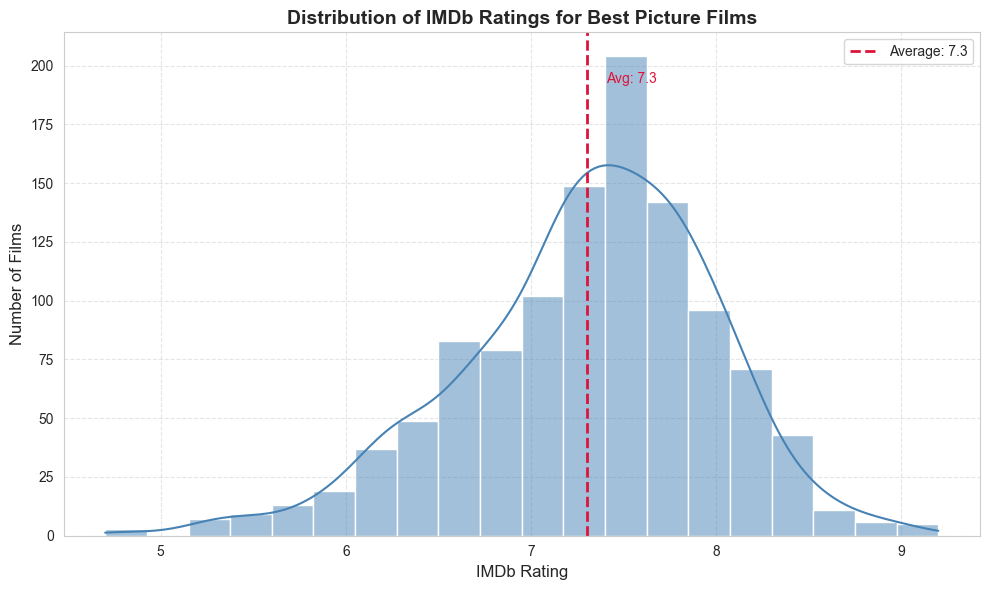

In [12]:
# Filter valid IMDb ratings
ratings_data = omdb_metadata["imdbRating"].dropna()

# Calculate average rating
avg_rating = ratings_data.mean()

# Create histogram with KDE overlay
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.histplot(ratings_data, bins=20, kde=True, color="#4682B4", edgecolor="white")

# Add vertical line for average rating
plt.axvline(avg_rating, color="crimson", linestyle="--", linewidth=2, label=f"Average: {avg_rating:.1f}")
plt.text(avg_rating + 0.1, plt.ylim()[1] * 0.9, f"Avg: {avg_rating:.1f}", color="crimson", fontsize=10)

# Titles and labels
plt.title("Distribution of IMDb Ratings for Best Picture Films", fontsize=14, fontweight='bold')
plt.xlabel("IMDb Rating", fontsize=12)
plt.ylabel("Number of Films", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


#### 📝 Summary of Results

The histogram reveals a fairly symmetrical distribution of IMDb ratings among Best Picture nominees and winners. Most films cluster between **6.5 and 8.0**, with a notable peak around the **7.3 average rating**.

There are very few films rated below 6.0 or above 8.5, suggesting that Best Picture films are generally well-received but rarely achieve extreme highs or lows in viewer scores. This consistency highlights a solid baseline of critical and audience acclaim.


### 📊 Average IMDb Ratings by Decade for Best Picture Nominees and Winners

This visualization explores how the average IMDb rating of Best Picture nominees and winners has evolved across different decades. It offers insight into whether audience reception has improved, declined, or remained consistent over time.


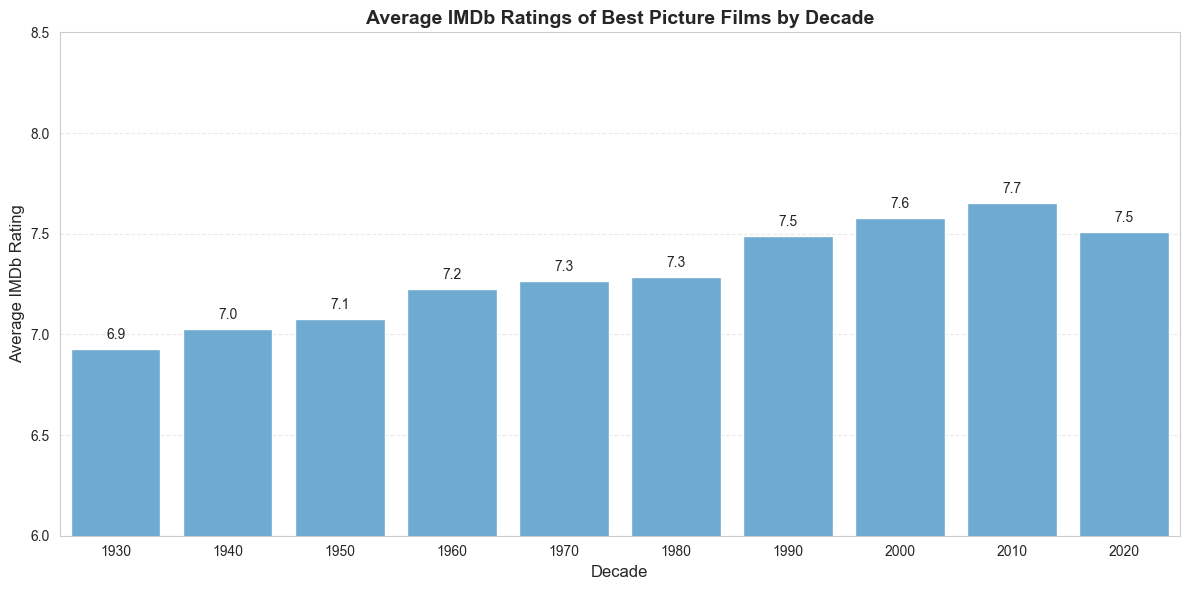

In [13]:
# Create a "decade" column
omdb_metadata["decade"] = (omdb_metadata["year"] // 10) * 10

# Group by decade and calculate average rating
decade_ratings = omdb_metadata.groupby("decade")["imdbRating"].mean().reset_index()

# Create the barplot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.barplot(data=decade_ratings, x="decade", y="imdbRating", color="#5DADE2")

# Annotate each bar with rating
for index, row in decade_ratings.iterrows():
    plt.text(x=index, y=row["imdbRating"] + 0.05, s=f"{row['imdbRating']:.1f}", ha='center', fontsize=10)

# Titles and labels
plt.title("Average IMDb Ratings of Best Picture Films by Decade", fontsize=14, fontweight="bold")
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Average IMDb Rating", fontsize=12)
plt.ylim(6, 8.5)
plt.grid(axis='y', linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


#### 📝 Summary of Results

This bar chart highlights a gradual increase in IMDb ratings for Best Picture nominees and winners from the 1930s to the 2010s. Starting with a rating of **6.9** in the 1930s, average ratings rose steadily each decade, peaking in the **2010s** at **7.7**. The **2020s** show a slight dip to **7.5**, though it's still among the highest.

These results suggest that audience sentiment toward Oscar-nominated and winning films has become more favorable over time, with more recent decades enjoying consistently strong ratings.


### 📊 Average IMDb Ratings by Genre

This visualization explores the relationship between film **genres** and their **average IMDb ratings** across all Best Picture nominees and winners. By aggregating genre-level scores, we can identify trends such as which genres tend to be more critically acclaimed, and which may perform lower on average.

We merge genre data from TMDb (`tmdb_genre_results`) with IMDb ratings from OMDb (`omdb_metadata`) to compute average ratings per genre. The output is a horizontal bar chart ranking genres by their average rating, offering a fun and insightful look at genre-based patterns in award-winning films.


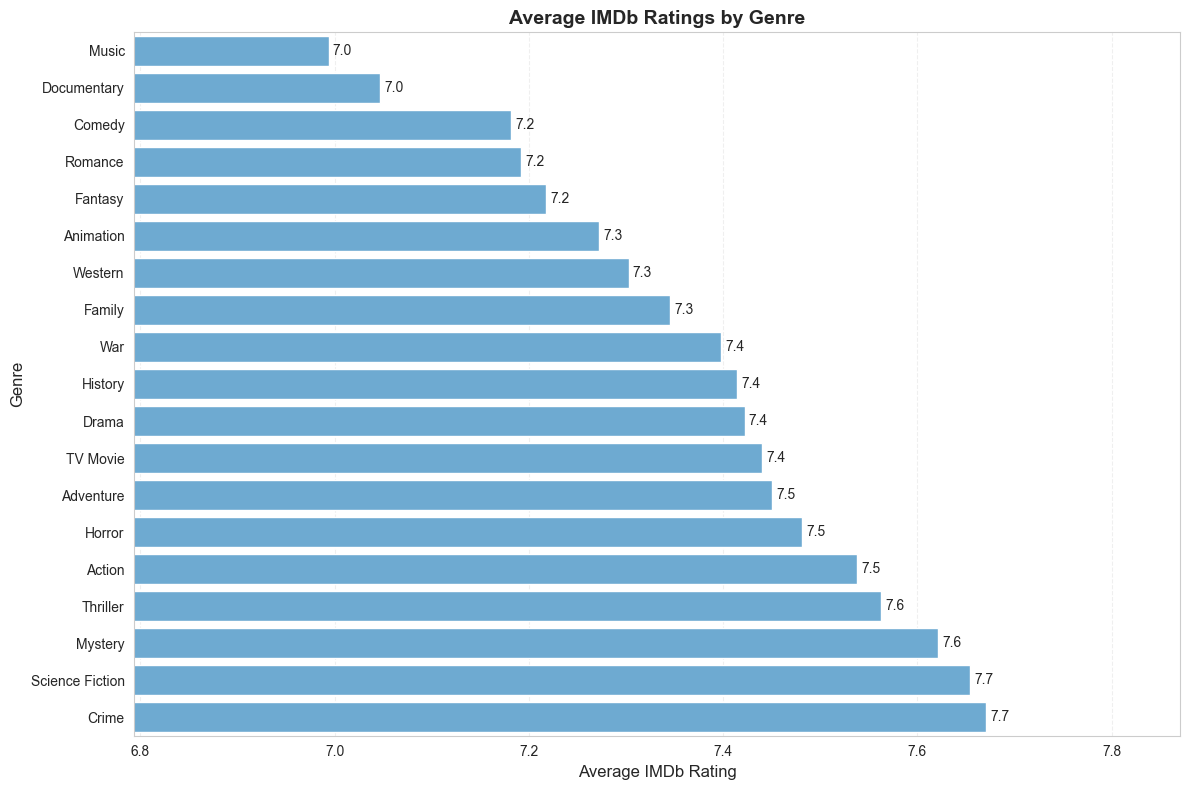

In [14]:
# Drop potential duplicate 'genre' column in omdb_metadata
omdb_metadata_clean = omdb_metadata.drop(columns=["genre"], errors="ignore")

# Merge genre data with IMDb ratings
genre_data = tmdb_genre_results.merge(omdb_metadata_clean, on=["film", "year"])

# Flatten the 'genre' column if it contains lists
genre_data = genre_data.explode("genre")

# Calculate average rating per genre
genre_summary = (
    genre_data.groupby("genre")["imdbRating"]
    .mean()
    .reset_index()
    .sort_values(by="imdbRating", ascending=True)
)

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
ax = sns.barplot(
    data=genre_summary,
    x="imdbRating",
    y="genre",
    color="#5DADE2"
)

# Annotate bars with rating values directly using container heights
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", label_type="edge", padding=3)

plt.title("Average IMDb Ratings by Genre", fontsize=14, fontweight="bold")
plt.xlabel("Average IMDb Rating", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.xlim(genre_summary["imdbRating"].min() - 0.2, genre_summary["imdbRating"].max() + 0.2)
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

#### 📝 Summary of Results

This visualization reveals that **Crime**, **Science Fiction**, and **Mystery** films have the **highest average IMDb ratings**, each scoring **7.6 or above**, suggesting these genres are consistently well-regarded among Best Picture nominees and winners. Close behind are **Thriller**, **Action**, and **Adventure** films, all performing strongly.

In contrast, genres like **Music** and **Documentary** have the **lowest average ratings**, falling below **7.0**, indicating that while they may be nominated, they tend to receive more mixed audience or critical reception.

The spread across genres is relatively tight—most average ratings cluster between **7.2 and 7.6**—but this breakdown still offers useful insight into which genres tend to be more critically favored in Oscar-recognized films.


### 📊 Average IMDb Ratings by Decade

This bar chart shows the **average IMDb ratings** of Best Picture nominees and winners grouped by decade. It helps us explore how critical reception of Oscar-nominated films may have changed over time.

Calculate the decade for each film, group them accordingly, and then chart the average ratings per group.

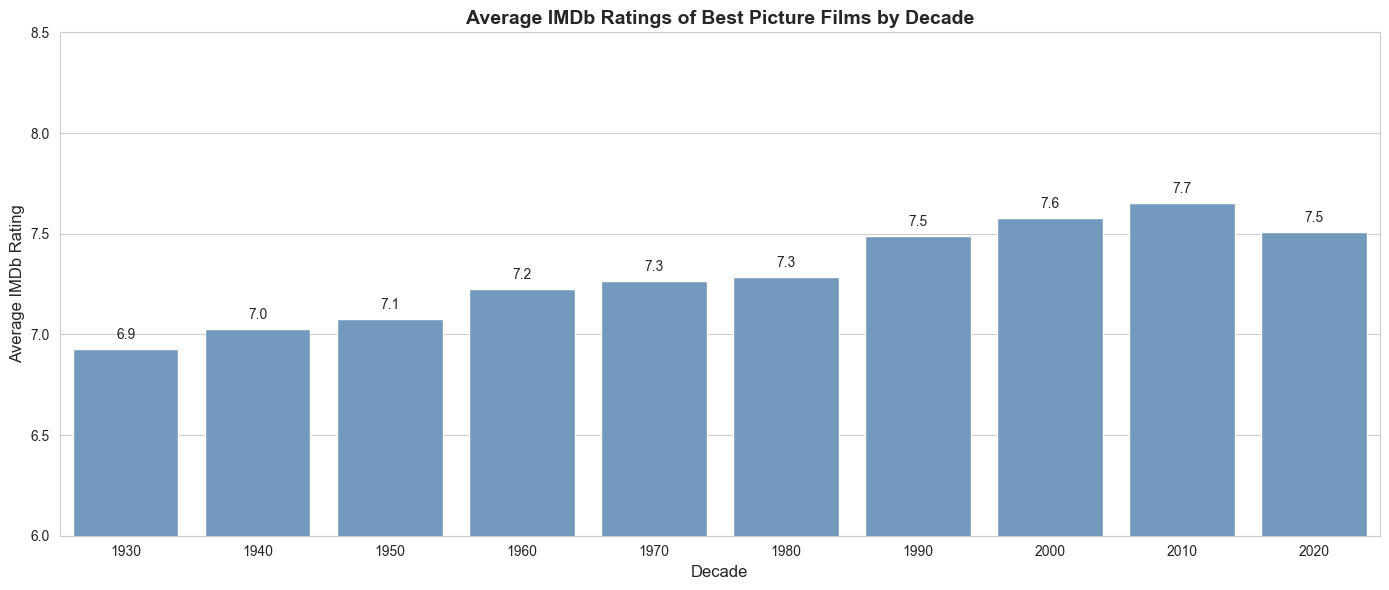

In [15]:
# Create decade column
decade_data = omdb_metadata_clean.copy()
decade_data["decade"] = (decade_data["year"] // 10) * 10

# Calculate average rating per decade
decade_avg = (
    decade_data.groupby("decade")["imdbRating"]
    .mean()
    .reset_index()
)

# Round values for labels
decade_avg["label"] = decade_avg["imdbRating"].round(1)

# Plot
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x="decade", y="imdbRating", data=decade_avg, color="#6699cc")

# Add labels above bars
for i, row in decade_avg.iterrows():
    ax.text(i, row["imdbRating"] + 0.05, f"{row['label']}", ha="center", fontsize=10)

plt.title("Average IMDb Ratings of Best Picture Films by Decade", fontsize=14, fontweight="bold")
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Average IMDb Rating", fontsize=12)
plt.ylim(6, 8.5)
plt.tight_layout()
plt.show()


#### 📝 Summary of Results

This chart tracks the changes in average IMDb ratings of Best Picture nominees and winners across decades.

💡 Key observations:
- Ratings have steadily increased from the 1930s to the 2010s.
- The highest average decade rating is the **2010s**, peaking at **7.7**.
- Earlier decades (1930s–1950s) had ratings below **7.2**, while later decades have generally scored higher.
- This suggests a trend toward more critically acclaimed films being nominated or winning Best Picture in recent years.

Overall, the Academy appears to be favoring films that resonate better with audiences and critics in modern times.


### 📊 Top 10 Highest-Grossing Best Picture Nominees and Winners

This visualization highlights the **Top 10 highest-grossing films** among Best Picture nominees and winners, based on their box office revenue. It helps us identify the most commercially successful Oscar contenders, offering a fun perspective for moviegoers who love big hits and blockbusters.

To ensure accuracy, the chart uses the cleaned `boxOffice_clean` values from the OMDb API data and sorts the data to find the top 10 earners. Titles are displayed clearly to show which award-winning films captured the most ticket sales.

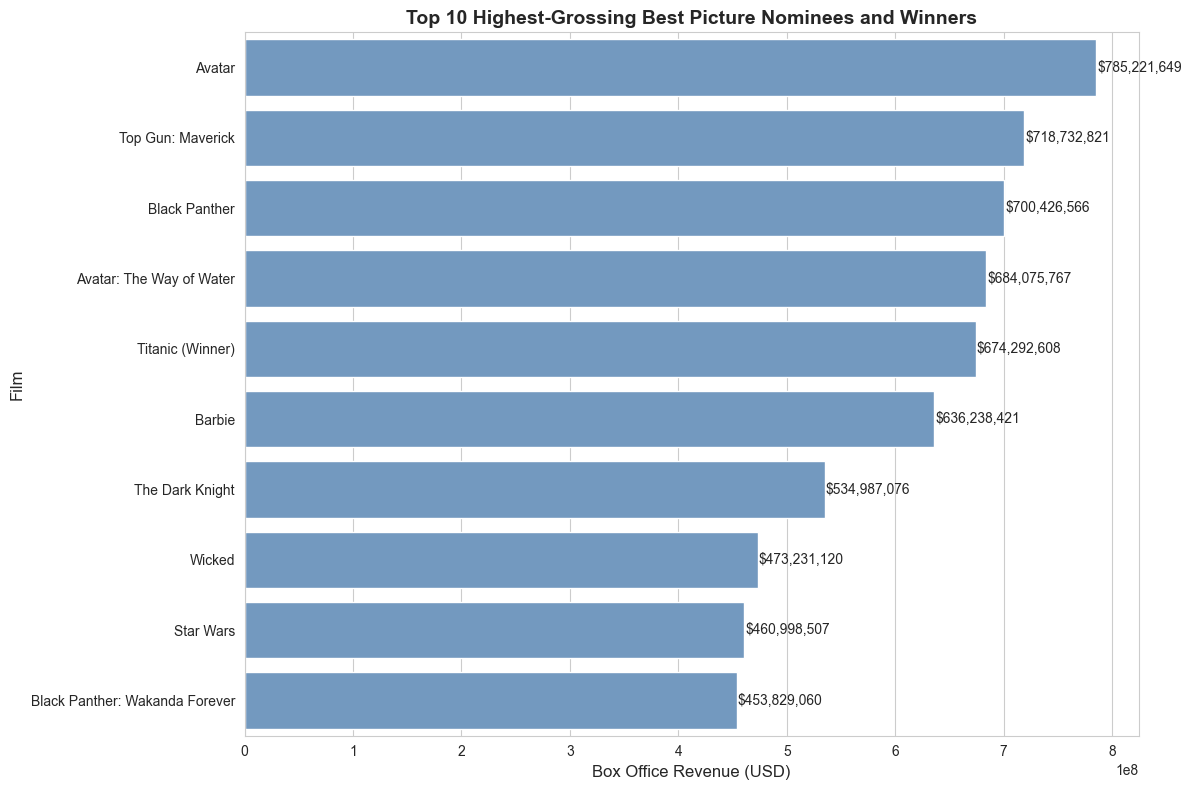

In [16]:
# Ensure winner column exists
if "winner" not in omdb_metadata_clean.columns:
    winning_titles = set(best_picture_wikipedia.loc[best_picture_wikipedia["status"] == "Winner", "film"])
    omdb_metadata_clean["winner"] = omdb_metadata_clean["film"].isin(winning_titles)

# Select Top 10 Highest-Grossing Films
highest_grossing = (
    omdb_metadata_clean.dropna(subset=["boxOffice_clean"])
    .sort_values(by="boxOffice_clean", ascending=False)
    .head(10)
)

# Append (Winner) to winners
highest_grossing = highest_grossing.copy()
highest_grossing["label"] = highest_grossing.apply(
    lambda row: f"{row['film']} (Winner)" if row.get("winner") == True else row['film'], axis=1
)

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
ax = sns.barplot(
    data=highest_grossing,
    y="label",
    x="boxOffice_clean",
    color="#6699cc"
)

# Add labels to bars
for index, value in enumerate(highest_grossing["boxOffice_clean"]):
    ax.text(
        value + 1e6,
        index,
        f"${value:,.0f}",
        va="center",
        fontsize=10
    )

plt.title("Top 10 Highest-Grossing Best Picture Nominees and Winners", fontsize=14, fontweight="bold")
plt.xlabel("Box Office Revenue (USD)", fontsize=12)
plt.ylabel("Film", fontsize=12)
plt.tight_layout()
plt.show()


#### 📝 Summary of Results

This bar chart reveals the **Top 10 box office giants** among Oscar-nominated or winning films. These titles earned the most money at the box office, showcasing their popularity with general audiences.

A `(Winner)` label next to a film’s name signifies that it **won** the Academy Award for Best Picture, making it easy to distinguish winners from other top-earning nominees.

💡 **Notably, only one of the films listed—_Titanic_—actually won Best Picture.** This highlights an interesting contrast between commercial success and critical recognition by the Academy. While all of these movies resonated with audiences, most didn’t take home the top prize.

It's a great reminder that blockbuster appeal doesn’t always translate into Oscar gold—but sometimes, it does.


### 📊 Total Box Office Revenue by Year for Best Picture Nominees and Winners

This visualization explores the **annual total box office revenue** for all Best Picture-nominated and winning films. By summing the earnings year by year, we can identify trends in commercial performance over time. This view helps everyday movie lovers understand which years were the biggest for Oscar-nominated films and how revenue patterns have shifted across decades.

The chart includes both nominees and winners, using data pulled from the OMDb API and cleaned in earlier steps. The x-axis shows the release year, and the y-axis shows the total box office gross for that year across all nominated or winning films.

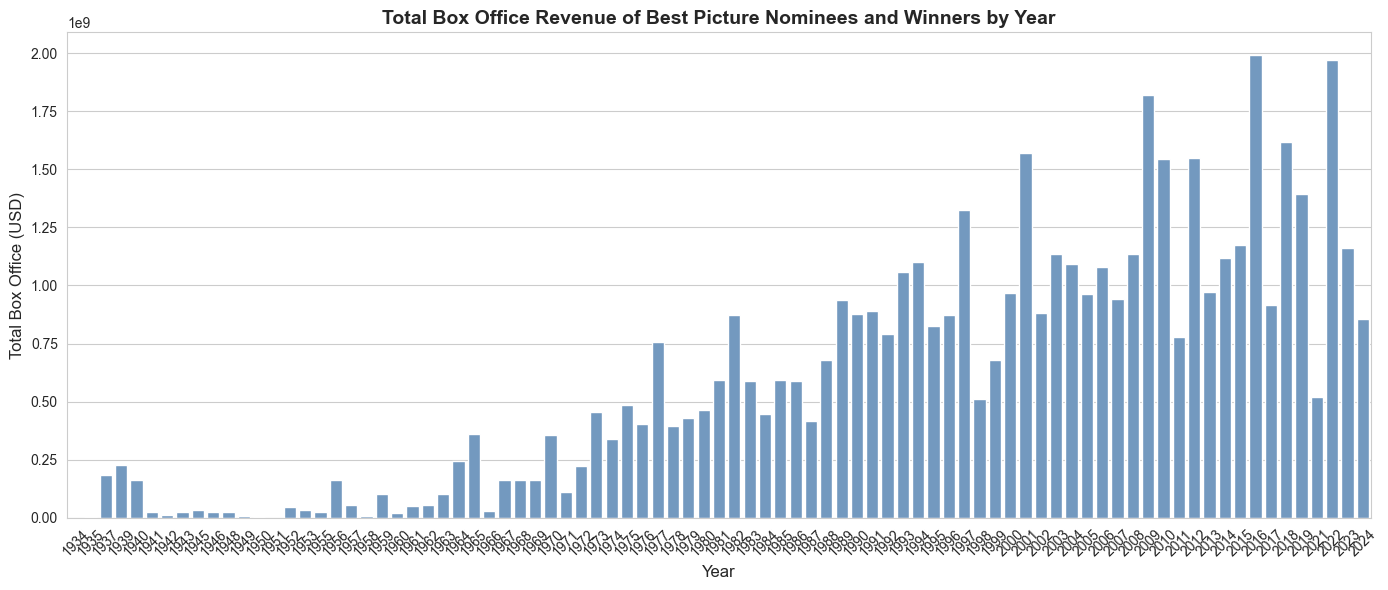

In [17]:
# Group data by year and sum box office revenue
yearly_box_office = (
    omdb_metadata_clean.dropna(subset=["boxOffice_clean", "year"])
    .groupby("year")["boxOffice_clean"]
    .sum()
    .reset_index()
)

# Plot the line chart
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=yearly_box_office,
    x="year",
    y="boxOffice_clean",
    color="#6699cc"
)

plt.xticks(rotation=45)
plt.title("Total Box Office Revenue of Best Picture Nominees and Winners by Year", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Box Office (USD)", fontsize=12)
plt.tight_layout()
plt.show()


#### 📝 Summary of Results

This bar chart presents a year-by-year view of the **total box office revenue** generated by Oscar-nominated and winning Best Picture films.

💡 Key observations:
- There's a **clear upward trend over time**, especially from the late 1980s onward, possibly reflecting inflation, global film distribution, and the rise of blockbuster-driven cinema.
- **Recent years**, such as 2010, 2018, and 2023, show some of the **highest grossing totals**—a testament to the growing intersection between **prestige filmmaking and commercial appeal**.
- Years like **1997 (Titanic)** and **2009 (Avatar)** stand out prominently as peak revenue years, driven by massive individual successes.

Overall, this visualization captures the **increasing box office power** of films recognized by the Academy, especially in the modern era.


### 📊 Top Rated Best Picture Nominees and Winners

This visualization showcases the **top 10 highest-rated Best Picture films** based on IMDb user ratings. By focusing on critical acclaim from general audiences, we highlight which nominated or winning films resonate most strongly with viewers.

We'll select the top-rated films from our cleaned dataset, sort by IMDb rating, and annotate the winners to spotlight their recognition by the Academy.

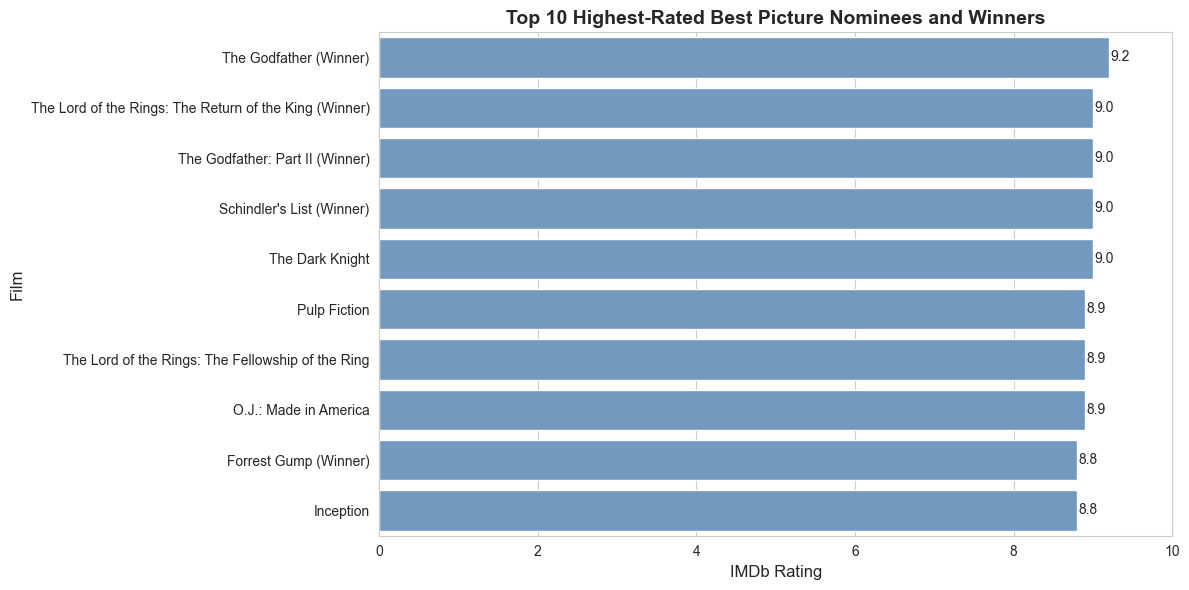

In [18]:
# Prepare data by sorting and filtering for top 10 highest-rated films
rating_chart_data = (
    omdb_metadata_clean.dropna(subset=["imdbRating"])
    .sort_values(by="imdbRating", ascending=False)
    .head(10)
    .copy()
)

# Merge with best_picture_wikipedia to get winner status
rating_chart_data = rating_chart_data.merge(
    best_picture_wikipedia[['film', 'status']], on='film', how='left'
)

# Label winning films
rating_chart_data["label"] = rating_chart_data.apply(
    lambda row: f"{row['film']} (Winner)" if row["status"] == "Winner" else row["film"], axis=1
)

# Sort again just in case merge disrupted order
rating_chart_data = rating_chart_data.sort_values(by="imdbRating", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(
    data=rating_chart_data,
    y="label",
    x="imdbRating",
    color="#6699cc"
)

# Add rating labels to bars
for i, row in rating_chart_data.iterrows():
    ax.text(
        row.imdbRating + 0.02,
        ax.get_yticks()[list(rating_chart_data.index).index(i)],
        f"{row.imdbRating:.1f}",
        va="center"
    )

plt.title("Top 10 Highest-Rated Best Picture Nominees and Winners", fontsize=14, fontweight="bold")
plt.xlabel("IMDb Rating", fontsize=12)
plt.ylabel("Film", fontsize=12)
plt.xlim(0, 10)
plt.tight_layout()
plt.show()


#### 📝 Summary of Results

This bar chart highlights the **top 10 Best Picture nominees and winners based on IMDb ratings**, offering a viewer-driven perspective on cinematic excellence.

💡 Key observations:
- All films in the top 10 are exceptionally rated, with scores ranging from **8.8 to 9.2**.
- **Five of the ten films are Best Picture winners**, including _The Godfather_, _Schindler's List_, and _The Return of the King_.
- Highly celebrated films like _The Dark Knight_, _Pulp Fiction_, and _Inception_ appear in this list despite not winning Best Picture, suggesting a **disconnect between public opinion and Academy decisions**.

This chart emphasizes how audience acclaim, as reflected in IMDb scores, often **elevates certain films to legendary status**, regardless of their outcome on Oscar night.


### 📊 IMDb Rating vs. Box Office Revenue

This scatter plot explores the relationship between **IMDb ratings** and **box office revenue** for Best Picture nominees and winners. By visualizing critical acclaim alongside financial success, we aim to discover whether top-rated films also tend to earn the most at the box office.

We'll highlight Best Picture winners with a different marker and color to distinguish them from nominees.

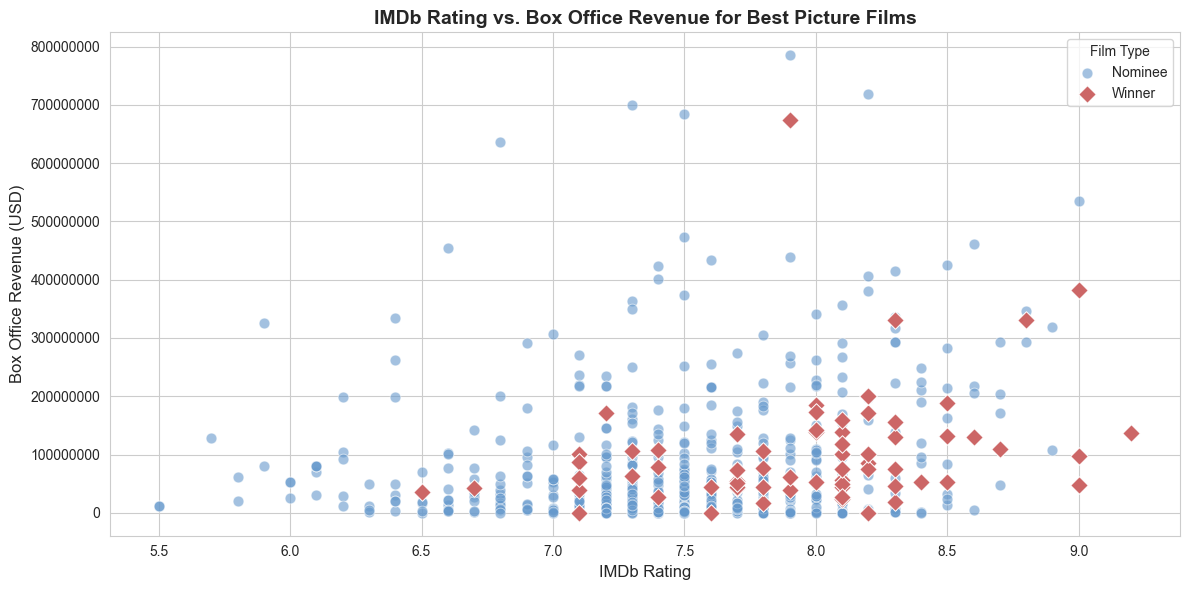

In [19]:
# Prepare data
rating_revenue_data = omdb_metadata_clean.dropna(subset=["imdbRating", "boxOffice_clean"])

# Merge with winner status
rating_revenue_data = rating_revenue_data.merge(
    best_picture_wikipedia[["film", "status"]], on="film", how="left"
)

# Map winners for plot styling
rating_revenue_data["is_winner"] = rating_revenue_data["status"] == "Winner"

# Plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Nominees
sns.scatterplot(
    data=rating_revenue_data[~rating_revenue_data["is_winner"]],
    x="imdbRating",
    y="boxOffice_clean",
    color="#6699cc",
    label="Nominee",
    s=60,
    alpha=0.6
)

# Winners
sns.scatterplot(
    data=rating_revenue_data[rating_revenue_data["is_winner"]],
    x="imdbRating",
    y="boxOffice_clean",
    color="#cc6666",
    label="Winner",
    s=80,
    marker="D"
)

plt.title("IMDb Rating vs. Box Office Revenue for Best Picture Films", fontsize=14, fontweight="bold")
plt.xlabel("IMDb Rating", fontsize=12)
plt.ylabel("Box Office Revenue (USD)", fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title="Film Type")
plt.tight_layout()
plt.show()


#### 📝 Summary of Results

This scatter plot examines whether critically acclaimed Best Picture films (as measured by IMDb user ratings) also performed strongly at the box office.

💡 Key observations:
- There is no strong visual correlation between IMDb ratings and box office revenue.
- A number of highly rated films (above 8.0) had relatively modest box office performance.
- Conversely, some top-earning films had average or below-average IMDb ratings.
- **Winners** (highlighted in red diamonds) are distributed throughout the plot, showing that Oscar victories do not necessarily guarantee massive box office success.

This chart highlights the **disconnect between critical acclaim and commercial performance**, emphasizing that popularity and prestige don't always go hand in hand.


### 📊 Total Revenue by Genre

This horizontal bar chart shows the **total box office revenue** for each genre represented among Best Picture nominees and winners. It helps reveal which genres tend to bring in the most money overall.

We’ll explode the genre column (since some films belong to multiple genres), group by genre, sum the revenue, and plot the totals.

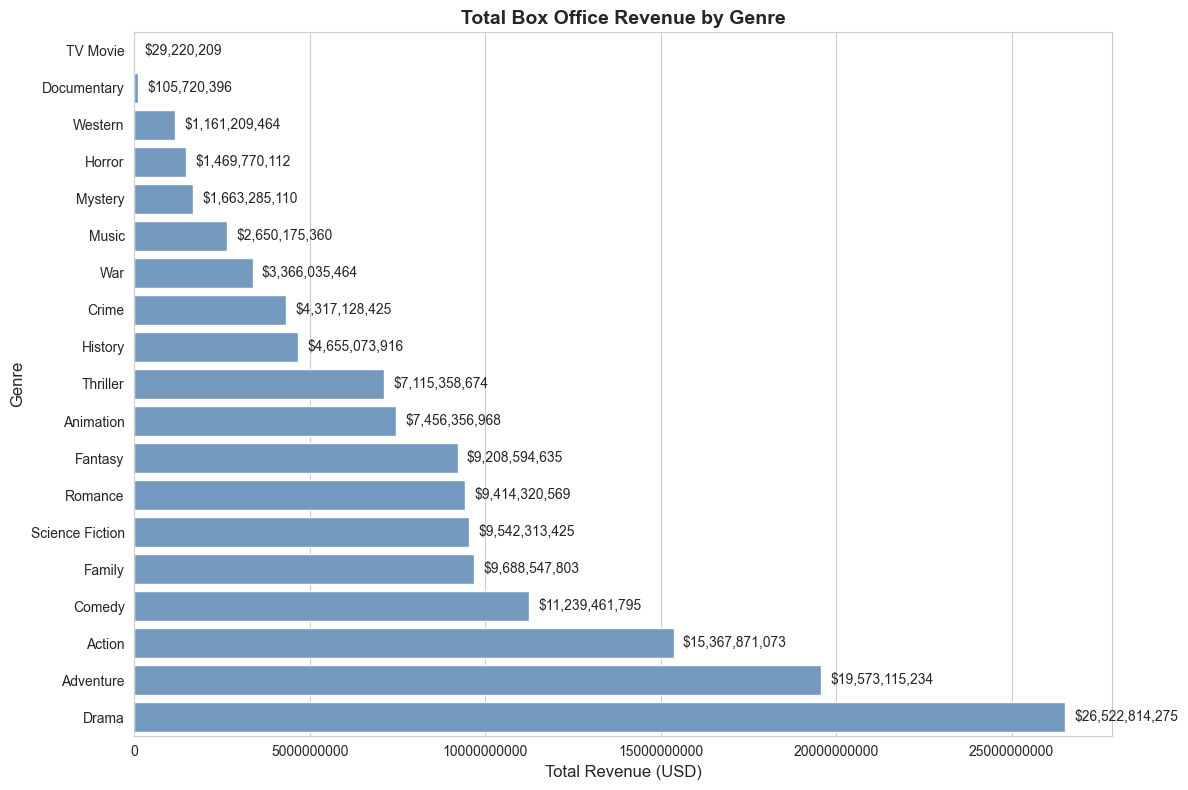

In [20]:
# Explode genres and calculate total revenue per genre
genre_revenue = omdb_metadata_clean.merge(tmdb_genre_results, on=["film", "year"], how="left")
genre_revenue = genre_revenue.rename(columns={"Genres": "genre"})
genre_revenue = genre_revenue.explode("genre")

genre_revenue_totals = (
    genre_revenue.groupby("genre")["boxOffice_clean"]
    .sum()
    .reset_index()
    .sort_values(by="boxOffice_clean", ascending=True)
)

# Plot
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
ax = sns.barplot(
    data=genre_revenue_totals,
    y="genre",
    x="boxOffice_clean",
    color="#6699cc"
)

# Add labels
for i, bar in enumerate(ax.patches):
    value = genre_revenue_totals.iloc[i]["boxOffice_clean"]
    label = f"${value:,.0f}"
    ax.text(
        bar.get_width() + genre_revenue_totals["boxOffice_clean"].max() * 0.01,
        bar.get_y() + bar.get_height() / 2,
        label,
        va="center",
        fontsize=10
    )

plt.ticklabel_format(style='plain', axis='x')
plt.title("Total Box Office Revenue by Genre", fontsize=14, fontweight="bold")
plt.xlabel("Total Revenue (USD)", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.tight_layout()
plt.show()

#### 📝 Summary of Results

This visualization breaks down which genres bring in the most revenue among Oscar-nominated and winning films.

💡 Key observations:
- **Drama** leads all genres in total revenue, unsurprising given how often it's represented at the Oscars.
- **Action**, **Adventure**, and **Science Fiction** also perform strongly, showing the earning power of blockbuster genres even within award contexts.
- **Documentary**, **TV Movie**, and **Music** genres fall at the lower end of the spectrum.

This reveals that critically acclaimed films can also achieve substantial commercial success, particularly in widely appealing genres.


### 📊 Total Revenue by Decade

This vertical bar chart displays the **total box office revenue** for all Best Picture nominees and winners **by decade**. It gives a high-level view of how movie earnings have evolved over time, and whether any decades stand out for especially high-grossing films.

We'll group the dataset by decade, sum the total box office revenue for each period, and plot the results.


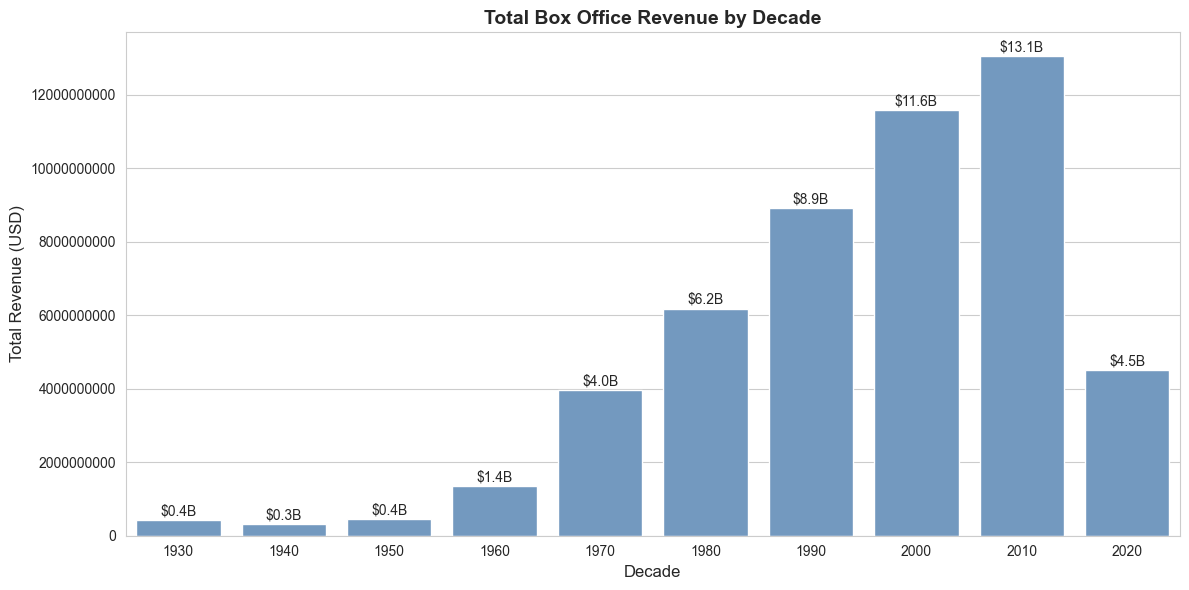

In [ ]:
# Calculate decade from year and sum revenue
revenue_by_decade = omdb_metadata_clean.copy()
revenue_by_decade["decade"] = (revenue_by_decade["year"] // 10) * 10

revenue_totals_by_decade = (
    revenue_by_decade.groupby("decade")["boxOffice_clean"]
    .sum()
    .reset_index()
    .sort_values("decade")
)

# Plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(
    data=revenue_totals_by_decade,
    x="decade",
    y="boxOffice_clean",
    color="#6699cc"
)

# Add labels
for i, bar in enumerate(ax.patches):
    value = revenue_totals_by_decade.iloc[i]["boxOffice_clean"]
    label = f"${value/1e9:.1f}B"
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + revenue_totals_by_decade["boxOffice_clean"].max() * 0.01,
        label,
        ha="center",
        fontsize=10
    )

plt.ticklabel_format(style='plain', axis='y')
plt.title("Total Box Office Revenue by Decade", fontsize=14, fontweight="bold")
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Total Revenue (USD)", fontsize=12)
plt.tight_layout()
plt.show()


#### 📝 Summary of Results

This chart shows the **total box office revenue** of Oscar-nominated and winning films across decades.

💡 Key insights:
- Box office revenue **grew consistently** from the 1960s through the 2010s.
- The **2010s** were the highest-grossing decade overall, with over **$13 billion** in revenue.
- Revenue in the **2020s** appears significantly lower, likely due to **pandemic disruptions**, the rise of streaming, and incomplete data for the decade.

These trends demonstrate how the commercial reach of Oscar-caliber films has expanded over time, particularly in the blockbuster-heavy 2000s and 2010s.


### 📊 Runtime vs. Box Office Revenue

This scatter plot visualizes the relationship between **runtime** and **box office revenue** for Best Picture nominees and winners. Each dot represents a film, with colors distinguishing winners from nominees. This visualization helps us determine whether longer (or shorter) films tend to earn more at the box office.

X and Y axes have been cleaned up to improve readability:
- Convert Y-axis values to **millions of USD**
- Limit the runtime range to a more typical span (60–210 minutes) to avoid skewed axes


In [36]:
print(omdb_metadata_clean.columns.tolist())
print(omdb_metadata_clean.dtypes.tolist())

['film', 'year', 'title_api', 'rated', 'released', 'runtime', 'director', 'writer', 'actors', 'plot', 'language', 'country', 'awards', 'poster', 'ratings', 'metascore', 'imdbRating', 'imdbVotes', 'imdbID', 'type', 'boxOffice', 'response', 'runtime_mins', 'boxOffice_clean', 'decade', 'winner']
[dtype('O'), dtype('int64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('float64'), dtype('float64'), Int64Dtype(), dtype('O'), dtype('O'), dtype('O'), dtype('O'), Int64Dtype(), dtype('float64'), dtype('int64'), dtype('bool')]


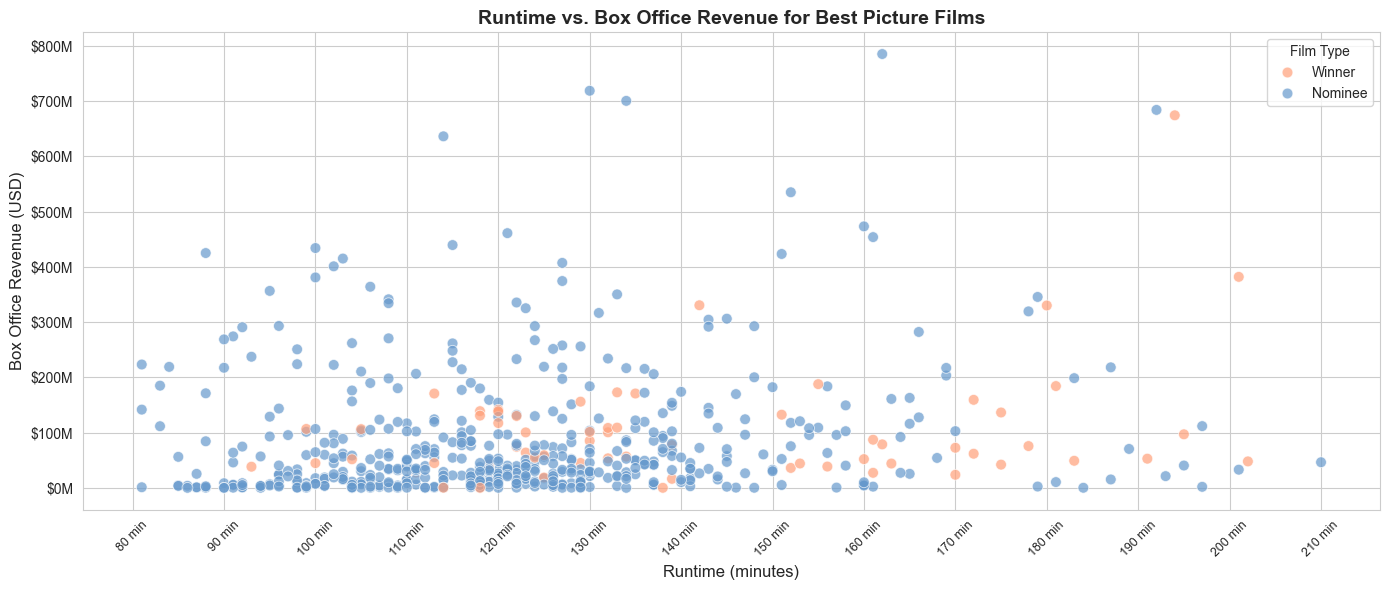

In [41]:
# Prepare data
runtime_revenue_data = omdb_metadata_clean.dropna(subset=["runtime", "boxOffice_clean"]).copy()
runtime_revenue_data["runtime_mins"] = pd.to_numeric(runtime_revenue_data["runtime_mins"], errors="coerce")
runtime_revenue_data = runtime_revenue_data.dropna(subset=["runtime_mins"])

# Assign status from existing 'winner' column
runtime_revenue_data["status"] = runtime_revenue_data["winner"].apply(lambda x: "Winner" if x else "Nominee")

# Filter typical runtime range and capture excluded films
excluded_films = runtime_revenue_data[
    (runtime_revenue_data["runtime_mins"] < 80) | (runtime_revenue_data["runtime_mins"] > 210)
][["film", "runtime_mins"]]

runtime_revenue_data = runtime_revenue_data[
    (runtime_revenue_data["runtime_mins"] >= 80) & (runtime_revenue_data["runtime_mins"] <= 210)
]


# Plot
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
ax = sns.scatterplot(
    data=runtime_revenue_data,
    x="runtime_mins",
    y="boxOffice_clean",
    hue="status",
    palette={"Winner": "#FFA07A", "Nominee": "#6699cc"},
    alpha=0.7,
    edgecolor="w",
    s=60
)

# Format Y-axis as millions
import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"${x/1e6:.0f}M"))

# Set X-axis ticks
xticks = list(range(80, 211, 10))
ax.set_xticks(xticks)
ax.set_xticklabels([f"{x} min" for x in xticks], rotation=45, fontsize=9)

plt.title("Runtime vs. Box Office Revenue for Best Picture Films", fontsize=14, fontweight="bold")
plt.xlabel("Runtime (minutes)", fontsize=12)
plt.ylabel("Box Office Revenue (USD)", fontsize=12)
plt.legend(title="Film Type")
plt.tight_layout()
plt.show()

#### 📝 Summary of Results

This scatter plot explores how the **length of a film** relates to its **box office success** among Oscar-nominated and winning films.

💡 Key insights:
- There is **no clear correlation** between runtime and box office performance.
- High-grossing films appear at a variety of runtimes, with some clustering in the **120–150 minute** range.
- Both **nominees and winners** are distributed similarly, showing no strong indication that runtime affects awards or revenue.
- Outliers were removed to improve readability and focus on the most common runtime window (80–210 minutes).

In summary, runtime appears to be a **neutral factor** in box office performance, with successful films found across all lengths.

📌 **Note:** The following films were excluded from this analysis due to atypical runtimes outside the 80–210 minute range:

In [42]:
excluded_films

,film,runtime_mins
1,The Brutalist,216
54,The Neighbors' Window,21
66,Hair Love,7
166,Inocente,40
380,A Close Shave,30
457,Balance,7
470,Tin Toy,5
758,Ben-Hur,212
797,Cleopatra,320
842,For Scent-imental Reasons,7


### 📊 Runtime vs. Box Office Revenue

This scatter plot visualizes the relationship between **runtime** and **box office revenue** for Best Picture nominees and winners. Each dot represents a film, with colors distinguishing winners from nominees. This visualization helps us determine whether longer (or shorter) films tend to earn more at the box office.

We'll also clean up the X and Y axes to improve readability:
- Convert Y-axis values to **millions of USD**
- Limit the runtime range to a more typical span (80–210 minutes)


In [ ]:
# Prepare data
runtime_revenue_data = omdb_metadata_clean.dropna(subset=["runtime", "boxOffice_clean"]).copy()
runtime_revenue_data["runtime_mins"] = pd.to_numeric(runtime_revenue_data["runtime_mins"], errors="coerce")
runtime_revenue_data = runtime_revenue_data.dropna(subset=["runtime_mins"])

# Assign status from existing 'winner' column
runtime_revenue_data["status"] = runtime_revenue_data["winner"].apply(lambda x: "Winner" if x else "Nominee")

# Filter typical runtime range and capture excluded films
excluded_films = runtime_revenue_data[
    (runtime_revenue_data["runtime_mins"] < 80) | (runtime_revenue_data["runtime_mins"] > 210)
][["film", "runtime_mins"]]

runtime_revenue_data = runtime_revenue_data[
    (runtime_revenue_data["runtime_mins"] >= 80) & (runtime_revenue_data["runtime_mins"] <= 210)
]

# Plot
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
ax = sns.scatterplot(
    data=runtime_revenue_data,
    x="runtime_mins",
    y="boxOffice_clean",
    hue="status",
    palette={"Winner": "#FFA07A", "Nominee": "#6699cc"},
    alpha=0.7,
    edgecolor="w",
    s=60
)

# Format Y-axis as millions
import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"${x/1e6:.0f}M"))

# Set X-axis ticks
xticks = list(range(80, 211, 10))
ax.set_xticks(xticks)
ax.set_xticklabels([f"{x} min" for x in xticks], rotation=45, fontsize=9)

plt.title("Runtime vs. Box Office Revenue for Best Picture Films", fontsize=14, fontweight="bold")
plt.xlabel("Runtime (minutes)", fontsize=12)
plt.ylabel("Box Office Revenue (USD)", fontsize=12)
plt.legend(title="Film Type")
plt.tight_layout()
plt.show()


#### 📝 Summary of Results

This scatter plot explores how the **length of a film** relates to its **box office success** among Oscar-nominated and winning films.

💡 Key insights:
- There is **no clear correlation** between runtime and box office performance.
- High-grossing films appear at a variety of runtimes, with some clustering in the **120–150 minute** range.
- Both **nominees and winners** are distributed similarly, showing no strong indication that runtime affects awards or revenue.
- Outliers were removed to improve readability and focus on the most common runtime window (80–210 minutes).

In summary, runtime appears to be a **neutral factor** in box office performance, with successful films found across all lengths.

📌 **Note:** The following films were excluded from this analysis due to atypical runtimes outside the 80–210 minute range:


In [55]:
print(excluded_films)

                           film  runtime_mins
1                 The Brutalist           216
54        The Neighbors' Window            21
66                    Hair Love             7
166                    Inocente            40
380               A Close Shave            30
457                     Balance             7
470                     Tin Toy             5
758                     Ben-Hur           212
797                   Cleopatra           320
842   For Scent-imental Reasons             7
860          Gone with the Wind           238
918         Knighty Knight Bugs             6
925          Lawrence of Arabia           227
1076       The Ten Commandments           220


### 📊 Average Box Office Revenue by Genre

This bar chart visualizes the **average box office revenue** earned by Best Picture-nominated and winning films, grouped by genre. It helps answer the question: _"Which types of films bring in the most money on average?"_

To do this, we:
- Use genre information enriched from the TMDb API
- Explode multi-genre listings to count each genre individually
- Calculate the **average revenue** for each genre
- Format and clean the output for readability


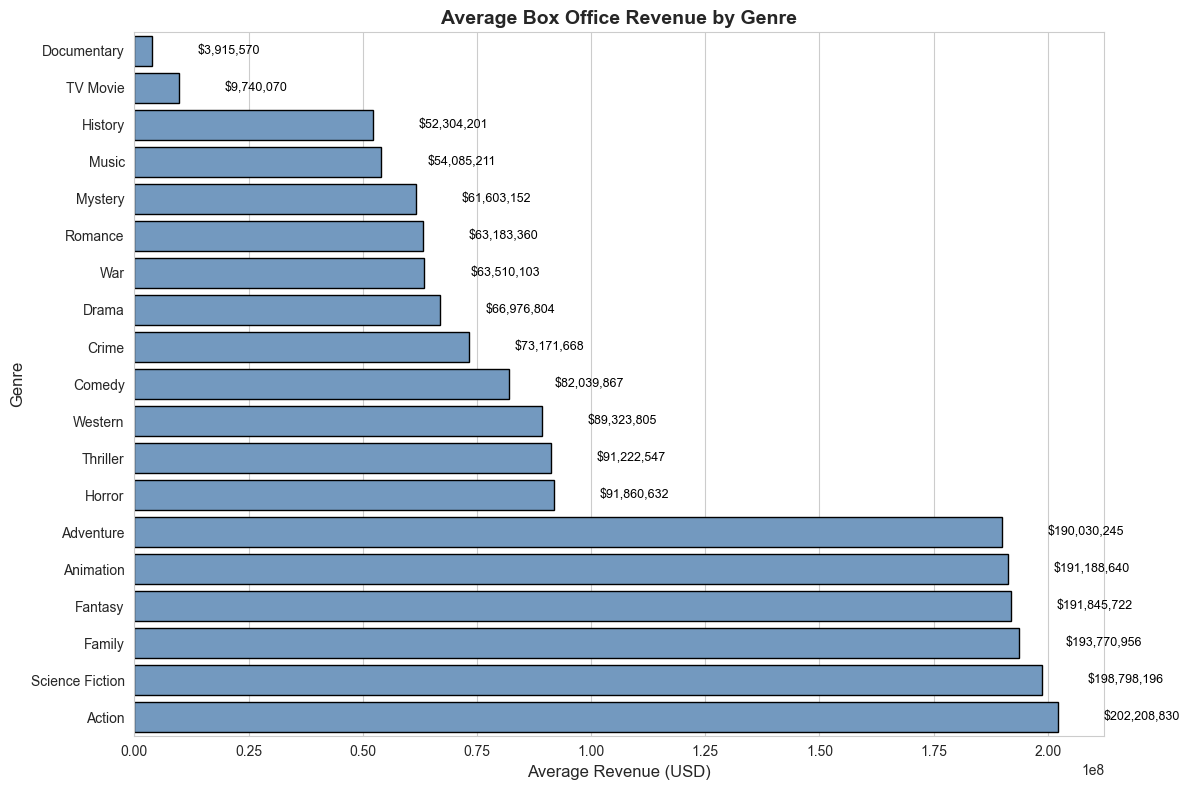

In [57]:
# Merge genre info from TMDb into OMDb data (temporary merge for this analysis)
avg_genre_revenue = omdb_metadata_clean.merge(
    tmdb_genre_results[["film", "year", "genre"]],
    on=["film", "year"],
    how="left"
)

# Explode genre lists and calculate average box office revenue
avg_genre_revenue = avg_genre_revenue.explode("genre")

# Drop rows without genre or box office info
avg_genre_revenue = avg_genre_revenue.dropna(subset=["genre", "boxOffice_clean"])

# Group by genre and calculate average revenue
avg_revenue_by_genre = (
    avg_genre_revenue.groupby("genre")["boxOffice_clean"]
    .mean()
    .reset_index()
    .sort_values(by="boxOffice_clean", ascending=True)
)

# Format revenue for display
avg_revenue_by_genre["formatted"] = avg_revenue_by_genre["boxOffice_clean"].apply(lambda x: f"${x:,.0f}")

# Plot
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
barplot = sns.barplot(
    data=avg_revenue_by_genre,
    x="boxOffice_clean",
    y="genre",
    color="#6699cc",
    edgecolor="black"
)

# Add data labels in correct positions
for bar, label in zip(barplot.patches, avg_revenue_by_genre["formatted"]):
    width = bar.get_width()
    barplot.text(
        width + 1e7,
        bar.get_y() + bar.get_height() / 2,
        label,
        va="center",
        ha="left",
        fontsize=9,
        color="black"
    )

plt.title("Average Box Office Revenue by Genre", fontsize=14, fontweight="bold")
plt.xlabel("Average Revenue (USD)", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.tight_layout()
plt.show()


#### 📝 Summary of Results

This visualization highlights how average box office revenue differs by film genre among Oscar-nominated and winning films.

💡 Key insights:
- Genres like **Adventure**, **Action**, and **Fantasy** consistently show **higher average revenue**, often exceeding $190M.
- **Documentary** and **TV Movie** genres appear on the lower end of the revenue spectrum.
- **Family**, **Science Fiction**, and **Crime** also perform well, underscoring their appeal to broader audiences.
- **Dramas** and **Romance** genres are widely represented among Oscar-nominated films but show **moderate or below-average financial performance**.

These trends suggest that genres with **broad commercial appeal** tend to yield **stronger financial returns**, even in the context of prestigious awards like Best Picture.


### 📊 Genre Frequency by Decade

This heatmap shows how frequently different genres appeared among Best Picture-nominated and winning films across the decades. It helps answer the question:
> _"How have genre trends shifted over time among Oscar-nominated films?"_

To generate this visualization:
- Merge the TMDb genre data with our cleaned OMDb dataset
- Explode multi-genre entries so each genre is counted individually
- Group and count how often each genre appeared per decade
- Visualize the results using a heatmap


### 📊 Frequency of Film Genres by Decade (Best Picture Nominees & Winners)

This heatmap illustrates how the **popularity of film genres** has evolved over time among Oscar-nominated and winning films. By counting the number of times each genre appeared in a given decade, we can trace historical trends and shifting preferences in Academy Award recognition.

To generate this visualization, we:
- Use genre data sourced from the TMDb API
- Explode multi-genre entries so each genre is individually counted
- Group and count by **genre** and **decade**
- Display the results using a heatmap for easy comparison


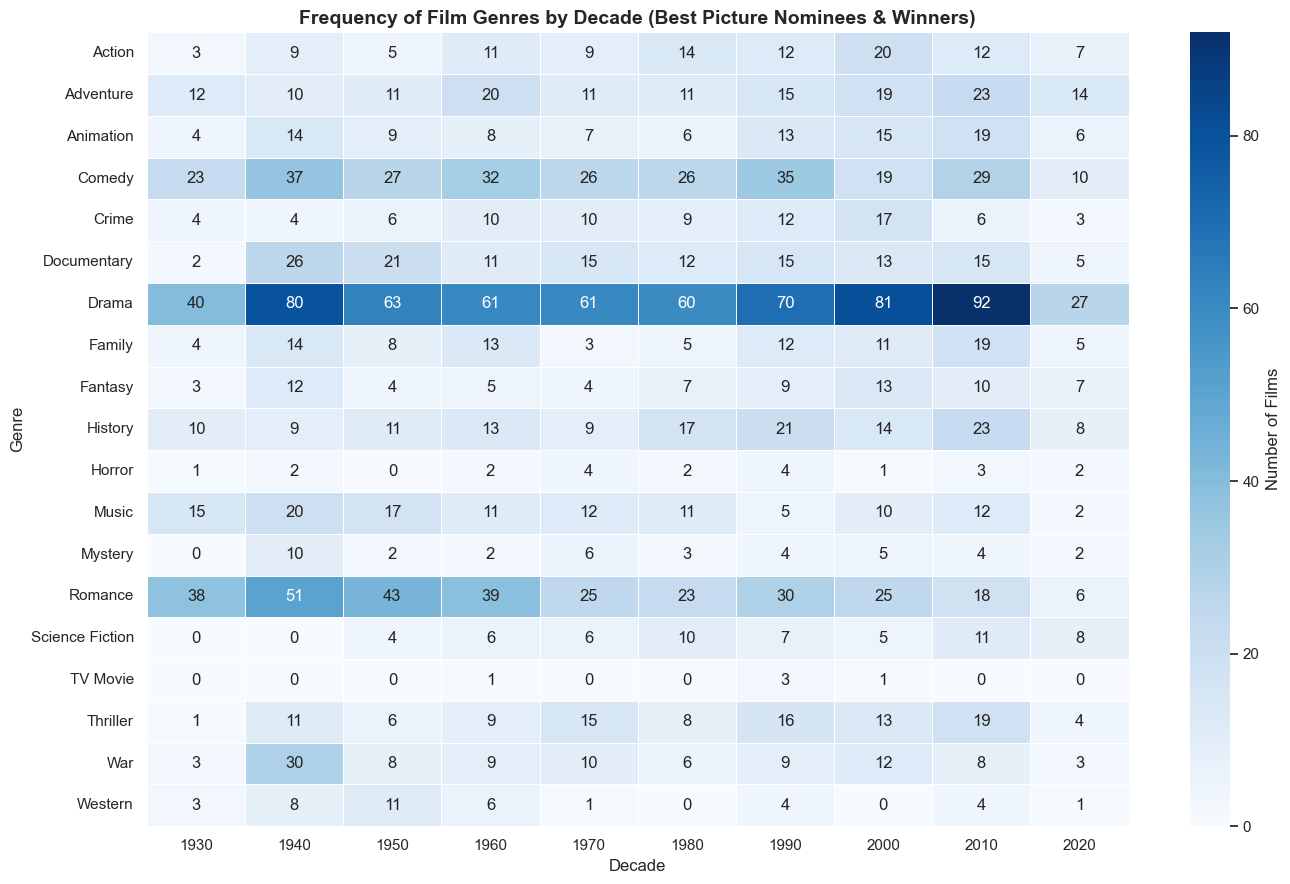

In [60]:
# Merge TMDb genres with OMDb box office data
genre_decade_data = omdb_metadata_clean.merge(
    tmdb_genre_results[["film", "year", "genre"]],
    on=["film", "year"],
    how="left"
)

# Explode genres and count by genre + decade
genre_decade_data = genre_decade_data.explode("genre").dropna(subset=["genre"])
genre_decade_counts = (
    genre_decade_data.groupby(["genre", "decade"])
    .size()
    .reset_index(name="count")
)

# Pivot for heatmap format
genre_pivot = genre_decade_counts.pivot(
    index="genre", columns="decade", values="count"
).fillna(0).astype(int)

# Plot
plt.figure(figsize=(14, 9))
sns.heatmap(
    genre_pivot,
    cmap="Blues",
    annot=True,
    fmt="d",
    linewidths=0.5,
    cbar_kws={"label": "Number of Films"}
)
plt.title("Frequency of Film Genres by Decade (Best Picture Nominees & Winners)", fontsize=14, fontweight="bold")
plt.xlabel("Decade")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


#### 📝 Summary of Results

This heatmap offers a fascinating look at how genre trends have shifted across decades:

💡 **Key insights:**
- **Drama** dominates across every decade, peaking in the 2010s with **92 films**.
- **Romance** and **Comedy** were highly prominent in earlier decades but have seen a decrease in more recent years.
- **Adventure**, **Thriller**, and **History** genres have shown relatively steady or increasing presence over time.
- Genres such as **Family**, **Science Fiction**, and **Fantasy** have seen moderate growth in more recent decades.
- Others like **Western** and **War** have clearly declined in frequency.

This visualization reveals how the Academy’s genre preferences have evolved, reflecting broader shifts in storytelling, culture, and audience appeal.
